In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
import glob

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
import statsmodels.api as sm

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()


## whole ice sheet

In [2]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))

cesm_ism = cesm_masks.grounded_ism.values #grounded ice sheet
cesm_area = cesm_masks.area.values #grid cell areas

In [3]:
snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM2_SNOW_hist.nc').mean(dim = 'ensemble').SNOW

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
snow = snow * cesm_ism * cesm_area #mask out non-antarctic area and convert from kg/m2/s to kg/s
snow = snow.groupby(snow.time.dt.year).mean()*3600*24*365 #kg/s to kg/year
snow = snow.sum(dim = ['lat','lon'])/(10**12) #kg to Gt

In [10]:
bp_year = get_bp_year(snow,30)
snow1 = snow.sel(year = slice(1850,bp_year))
snow2 = snow.sel(year = slice(bp_year,2015))

trend1 = linregress(snow1.year, snow1.values)
line1 = snow1.year*trend1.slope+trend1.intercept
trend2 = linregress(snow2.year, snow2.values)
line2 = snow2.year*trend2.slope + trend2.intercept

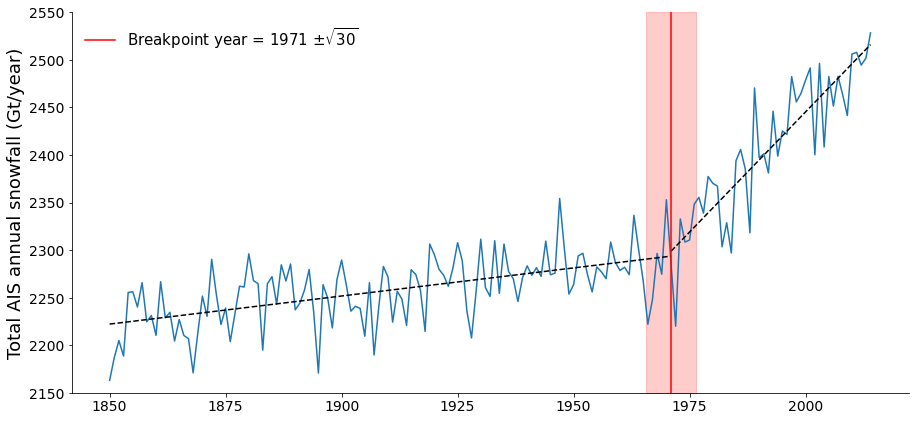

In [24]:
fig, ax = plt.subplots(1,1,figsize = (15,7))
ax.plot(snow.year, snow)
ax.plot(snow1.year, line1, 'k--')
ax.plot(snow2.year, line2, 'k--')
ax.plot([bp_year, bp_year],[2150,2550], 'r', label = 'Breakpoint year = 1971 $\pm \sqrt{30}$ ')
ax.fill_between([bp_year-np.sqrt(30), bp_year+np.sqrt(30)], [2150,2150], [2550,2550], color = 'red', alpha = 0.2)
ax.set_ylim([2150,2550])
ax.legend(frameon = False,prop={'size': 15})
ax.set_ylabel('Total AIS annual snowfall (Gt/year)', fontsize = 18)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=14)
plt.savefig('breakpoint_year.png', dpi = 300, bbox_inches = 'tight')

## By region

In [40]:
region_masks = glob.glob('/glade/work/devond/AIS_masks/basin_masks/*Fullbasins*.nc')
snow = xr.load_dataset(f'{home_dir}CESM/snow/CESM2_SNOW_hist.nc').mean(dim = 'ensemble').SNOW

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [48]:
#region_masks = region_masks[0:1]
bp_year_map = np.zeros((snow.values.shape[1], snow.values.shape[2]))
for mask_file in region_masks:
    mask = xr.open_dataset(mask_file).Zwallybasins
    mask = mask.sel(lat = slice(-90,-60)).values
    mask[mask>0]=1
    mask[mask==0]=np.nan
    
    snow_temp = snow * mask * cesm_area #mask out non-antarctic area and convert from kg/m2/s to kg/s
    snow_temp = snow_temp.groupby(snow_temp.time.dt.year).mean()*3600*24*365 #kg/s to kg/year
    snow_temp = snow_temp.sum(dim = ['lat','lon'])/(10**12) #kg to Gt
    bp_year = get_bp_year(snow_temp,30)
    bp_year_map[mask==1] = bp_year
    

In [49]:
cesm_ism_full = cesm_masks.full_ism.values
lon = snow.lon.values
lat = snow.lat.values
bp_year_map2, lon2 = add_cyclic_point(bp_year_map, coord = lon)
cesm_ism_full2, lon2 = add_cyclic_point(cesm_ism_full, coord = lon)

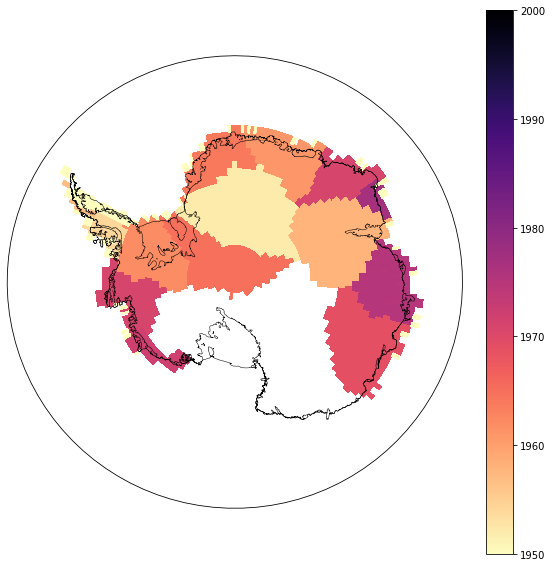

In [52]:
fig = plt.figure(figsize = (10,10))
gs=GridSpec(1,1)

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, lat, bp_year_map*cesm_ism_full2,transform = crs_ll, cmap = 'magma_r', vmin = 1950, vmax = 2000)
plt.colorbar(im)

plt.savefig('bp_year.png', dpi = 300)

## each pixel

In [79]:
cesm_ism_full = cesm_masks.full_ism.values
cesm_ism_full[cesm_ism_full==0] = np.nan
cesm_ism_full[cesm_ism_full>0] = 1

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
snow_map = xr.load_dataset(f'{home_dir}CESM/snow/CESM2_SNOW_hist.nc').mean(dim = 'ensemble').SNOW
snow_map = snow_map.groupby(snow_map.time.dt.year).mean()*3600*24*365 *cesm_ism_full #kg/m2/s to kg/m2/year (mmwe/yr)
lat = snow_map.lat.values
lon = snow_map.lon.values
snow_map

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'SNOW' (year: 165, lat: 32, lon: 288)>
array([[[65.60309601, 65.60307312, 65.60306549, ..., 65.60308838,
         65.60308838, 65.60307312],
        [63.65787888, 63.51745987, 63.38792801, ..., 64.03985596,
         63.91131973, 63.79403687],
        [54.69017792, 54.27809906, 53.86706924, ..., 56.10931015,
         55.62394333, 55.13364792],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[64.18530273, 64.1853714 , 64.18528748, ..., 64.18545532,
         64.1854248 , 64.18531036],
        [62.16879654, 62.087883  , 62.04992294, ..., 62.39496613,
         62.30937195, 62.24188232],
        [53.8431282 , 53.44910812, 53.0651207 , ..., 55.07045364,
         54.67733765, 54.26052094],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[65.63167572, 65.63169861, 65.63169861, ..., 65.63166809,
         65.63165283, 65.63165283],
        [62.94513702, 62.83274841, 62.73875809, ..., 63.17959976,
         63.11933136, 63.05308533],
        [53.65630341, 53.23081207, 52.83158875, ..., 54.97166061,
         54.54243469, 54.1208992 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       ...,

       [[74.90621948, 74.90623474, 74.90626526, ..., 74.90620422,
         74.90620422, 74.90620422],
        [71.29277039, 71.15449524, 71.05236816, ..., 71.66116333,
         71.54302216, 71.44566345],
        [60.88117981, 60.46235657, 60.04359818, ..., 62.31788254,
         61.82097244, 61.34484482],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[79.41758728, 79.41756439, 79.41756439, ..., 79.41756439,
         79.41756439, 79.41757965],
        [75.73555756, 75.60434723, 75.49325562, ..., 76.01781464,
         75.92318726, 75.85533142],
        [64.80290985, 64.35147858, 63.94710159, ..., 66.20832825,
         65.73820496, 65.28768921],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[82.18608856, 82.18602753, 82.1860733 , ..., 82.18606567,
         82.18608856, 82.1860733 ],
        [78.1397171 , 78.00195312, 77.8983078 , ..., 78.4246521 ,
         78.34320831, 78.26187897],
        [64.33221436, 63.82767487, 63.33332062, ..., 65.75373077,
         65.29547119, 64.83337402],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... -61.72775 -60.78534
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.7

In [116]:
year_map = np.zeros((32,288))
for i in range(len(lat)):
    for j in range(len(lon)):
        print(lat[i], lon[j])
        temp = snow_map.sel(lat = lat[i], lon = lon[j])
        if not np.isnan(temp.mean()):
            temp_y = get_bp_year(temp)
            year_map[i,j] = temp_y

-90.0 0.0
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 1.25
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 2.5
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 3.75
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 5.0
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 6.25
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 7.5
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 8.75
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 10.0
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 11.25
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 12.5
[1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1981, 1984]
-90.0 13.75
[

KeyboardInterrupt: 

In [ ]:
year_map2, lon2 = add_cyclic_point(year_map, coord = lon)
cesm_ism_full2, lon2 = add_cyclic_point(cesm_ism_full, coord = lon)

In [ ]:
fig = plt.figure(figsize = (10,10))
gs=GridSpec(1,1)

ax1 = plt.subplot(gs[0],projection=crs_sp)
plot_antarctica(ax1,-60)
im = ax1.pcolormesh(lon2, lat, year_map2*cesm_ism_full2,transform = crs_ll, cmap = 'magma_r')
plt.colorbar(im)

plt.savefig('bp_year.png', dpi = 300)

## Larson C

In [56]:
snow2 = convert_lon(snow_map)

lat_lc = -67.499998 
lon_lc = -62.499998

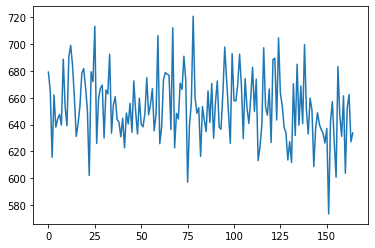

In [61]:
snow_lc = snow2.sel(lat = lat_lc, lon = lon_lc, method = 'nearest')
plt.plot(snow_lc.values)

In [85]:
t = get_bp_year(snow_lc)

In [86]:
t

nan